In [1]:
import numpy as np
import cvxpy as cp
import scipy.io as sio

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import pickle

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Image denoising via sparse representation 

In [2]:
from sklearn.decomposition import MiniBatchDictionaryLearning

In [18]:
from models.ALISTA import ALISTA
from models.ALDCISTA import ALDC_ISTA
from models.LISTA import LISTA

from utils.train import train_U, layerwise_train, layerwise_train_DC, layerwise_train_U, layerwise_train_DC_U
from utils.synthetic_data import SyntheticSignals

In [4]:
class ImagePatchDataset(Dataset):
    def __init__(self, folder_path, patch_size=(16, 16), total_patches=None, transform=None, SNR=None):
        self.folder_path = folder_path
        self.patch_size = patch_size
        self.transform = transform
        self.image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('png', 'jpg', 'jpeg'))]
        self.num_images = len(self.image_files)
        self.patches_per_image = total_patches // self.num_images if total_patches else None
        self.SNR = SNR
        
    def __len__(self):
        if self.patches_per_image:
            return self.patches_per_image * self.num_images
        return sum((image_width // self.patch_size[0]) * (image_height // self.patch_size[1]) 
                   for image_path in self.image_files 
                   for image_width, image_height in [Image.open(image_path).size])

    def __getitem__(self, idx):
        image_idx = idx % self.num_images  
        image_path = self.image_files[image_idx]
        image = Image.open(image_path).convert('L')  

        # Calculate the grid of patches for the image
        image_width, image_height = image.size
        grid_cols = image_width // self.patch_size[0]
        grid_rows = image_height // self.patch_size[1]

        # Compute patch coordinates from idx
        patch_idx = idx // self.num_images  
        row = patch_idx // grid_cols
        col = patch_idx % grid_cols

        x = col * self.patch_size[0]
        y = row * self.patch_size[1]

        patch = image.crop((x, y, x + self.patch_size[0], y + self.patch_size[1]))

        # Convert patch to numpy array for noise addition
        patch_np = np.array(patch, dtype=np.float32)

        # Add Gaussian noise
        if self.SNR is not None:
            patch_np = self.add_gaussian_noise(patch_np)

        if self.transform:
            patch_np = self.transform(patch_np)

        return patch_np

    def add_gaussian_noise(self, patch):
        # Signal and noise calculation
        signal_power = np.mean(patch ** 2)
        noise_power = signal_power / (10 ** (self.SNR / 10))
        noise = np.random.normal(0, np.sqrt(noise_power), patch.shape)
        noisy_patch = patch + noise
        noisy_patch = np.clip(noisy_patch, 0, 255).astype(np.uint8)
        return noisy_patch

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Lambda(lambda x: x.view(-1))  
])

# Parameters
train_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\train"
val_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\val"
test_folder_path = r"C:\Users\Leonardo\Documents\GitHub\ModelBasedDL4SCA\Sparse analysis\real_data\images\test"

patch_size = (16, 16)
total_patches = 10000  # Control the total number of patches in the dataset
batch_size = 50
shuffle = False

# Create dataset and dataloader
train_dataset = ImagePatchDataset(train_folder_path, patch_size=patch_size, total_patches=10000, transform=transform, SNR = None)
val_dataset = ImagePatchDataset(val_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = None)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

In [6]:
all_train_patches = []
for patches in train_dataloader:
    all_train_patches.append(patches.numpy())

all_train_patches = np.concatenate(all_train_patches, axis=0)

all_val_patches = []
for patches in val_dataloader:
    all_val_patches.append(patches.numpy())

all_val_patches = np.concatenate(all_val_patches, axis=0)

In [10]:
from sklearn.base import BaseEstimator
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.model_selection import GridSearchCV
import numpy as np

# Function to calculate the reconstruction error
def calculate_reconstruction_error(patches, dictionary):
    # Encode the data using the learned dictionary
    sparse_codes = dictionary.transform(patches)
    # Reconstruct the patches
    reconstructed_patches = np.dot(sparse_codes, dictionary.components_)
    # Calculate the mean squared reconstruction error
    mse = np.mean((patches - reconstructed_patches) ** 2)
    return mse

# Custom Dictionary Learning Wrapper compatible with scikit-learn's GridSearchCV
class DictionaryLearningWrapper(BaseEstimator):
    def __init__(self, n_components=512, alpha=1.0):
        self.n_components = n_components
        self.alpha = alpha
        self.dict_learner = MiniBatchDictionaryLearning(n_components=self.n_components, alpha=self.alpha, fit_algorithm='cd')

    # Required method for compatibility with GridSearchCV
    def get_params(self, deep=True):
        return {'n_components': self.n_components, 'alpha': self.alpha}

    # Required method for compatibility with GridSearchCV
    def set_params(self, **params):
        self.n_components = params.get('n_components', self.n_components)
        self.alpha = params.get('alpha', self.alpha)
        self.dict_learner = MiniBatchDictionaryLearning(n_components=self.n_components, alpha=self.alpha, fit_algorithm='cd')
        return self

    def fit(self, X):
        self.dict_learner.fit(X)
        return self

    def transform(self, X):
        return self.dict_learner.transform(X)

    def components_(self):
        return self.dict_learner.components_

    def score(self, X):
        # Minimize reconstruction error
        return -calculate_reconstruction_error(X, self.dict_learner)

# Define the parameter grid for alpha
param_grid = {'alpha': [0.01, 0.05, 0.1]}  # You can extend this range

# Initialize the grid search
n_components = 512
dictionary_model = DictionaryLearningWrapper(n_components=n_components, alpha=1)

# Wrap the model and apply GridSearchCV for alpha optimization
grid_search = GridSearchCV(estimator=dictionary_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(all_train_patches)

# Best alpha and the corresponding dictionary
best_alpha = grid_search.best_params_['alpha']
best_dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=best_alpha, fit_algorithm='cd')
best_dictionary = best_dict_learner.fit(all_train_patches).components_

print(f"Best alpha: {best_alpha}")

Best alpha: 0.01


In [8]:
n_components = 512
dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=0.1, fit_algorithm = 'cd')
dictionary = dict_learner.fit(all_train_patches).components_

In [9]:
train_sparse_codes = dict_learner.transform(all_train_patches)
val_sparse_codes = dict_learner.transform(all_val_patches)

In [13]:
test_dataset = ImagePatchDataset(test_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = 20)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [14]:
all_test_patches = []
for patches in test_dataloader:
    all_test_patches.append(patches.numpy())

all_test_patches = np.concatenate(all_test_patches, axis=0)

In [15]:
all_test_patches.shape

(1000, 256)

In [16]:
sparse_codes = dict_learner.transform(all_test_patches)

# Step 2: Reconstruct the patches from sparse codes and dictionary
reconstructed_patches = np.dot(sparse_codes, dictionary)

# Step 3: Compute the MSE (mean squared error)
mse = mean_squared_error(all_test_patches, reconstructed_patches)

# Step 4: Compute the variance of the original patches (normalization factor)
variance = np.mean(all_train_patches ** 2)

# Step 5: Compute NMSE in decibels
nmse_db = 10 * np.log10(mse / variance)

In [17]:
nmse_db

-67.91654586791992

In [18]:
sparse_codes = dict_learner.transform(all_test_patches)

# Step 2: Count the number of non-zero elements in each sparse code
non_zero_counts = np.count_nonzero(sparse_codes, axis=1)

# Step 3: Calculate the sparsity (fraction of non-zero elements) for each sample
sparsity_per_sample = non_zero_counts / sparse_codes.shape[1]

# Step 4: Calculate the average sparsity over all samples
average_sparsity = np.mean(sparsity_per_sample)

In [19]:
average_sparsity

0.048828125

In [20]:
class PatchCodeDataset(Data.Dataset):
    def __init__(self, patches, codes):
        # Convert NumPy arrays to PyTorch tensors
        self.y = torch.from_numpy(patches).float()  # the noisy patches
        self.x = torch.from_numpy(codes).float()    # the sparse codes
        
        assert self.y.shape[0] == self.x.shape[0], "Mismatched number of samples in y and x"
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        # Return the pairs (y, x)
        return self.y[idx], self.x[idx]

def get_patch_code_loader(patches, codes, batch_size=256, shuffle=True):
    # Create the dataset
    dataset = PatchCodeDataset(patches, codes)
    
    # Create a data loader
    return Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [21]:
train_data_loader = get_patch_code_loader(all_train_patches, train_sparse_codes, batch_size=256)
val_data_loader = get_patch_code_loader(all_val_patches, val_sparse_codes, batch_size=256)

In [22]:
D = torch.from_numpy(dictionary.astype(np.float32)).T

# Supervised version


In [25]:
model_1 = LISTA(torch.clone(D), 1, T = 18)
layerwise_train(model_1, train_data_loader, val_data_loader, 'LISTA', lr = 3e-3, ft_lr = 3e-5, verbose=True)

===== Training Layer 1/19 =====
Layer 1, Epoch 1/100, Train NMSE (dB): -2.012349, Validation NMSE (dB): -3.763253
Layer 1, Epoch 11/100, Train NMSE (dB): -3.900611, Validation NMSE (dB): -4.102471
Layer 1, Epoch 21/100, Train NMSE (dB): -3.989777, Validation NMSE (dB): -4.110286
Layer 1, Epoch 31/100, Train NMSE (dB): -4.057886, Validation NMSE (dB): -4.225556
Layer 1, Epoch 41/100, Train NMSE (dB): -4.095104, Validation NMSE (dB): -4.187495
Early stopping triggered after 45 epochs
===== Finished Training Layer 1/19 =====

===== Fine-Tuning the Entire Network =====
Fine-Tune Epoch 1/100, Train NMSE (dB): -4.100740, Validation NMSE (dB): -4.260142
Fine-Tune Epoch 11/100, Train NMSE (dB): -4.184634, Validation NMSE (dB): -4.321698
Fine-Tune Epoch 21/100, Train NMSE (dB): -4.185538, Validation NMSE (dB): -4.321069
Early stopping for fine-tuning triggered after 27 epochs
===== Finished Fine-Tuning =====

===== Training Layer 2/19 =====
Layer 2, Epoch 1/100, Train NMSE (dB): -3.256227, Vali

({'Layer_1': array([-2.01234912, -3.53019792, -3.62271034, -3.69347016, -3.73892682,
         -3.78521398, -3.80653188, -3.83056044, -3.85406731, -3.87576886,
         -3.90061074, -3.91597997, -3.93168436, -3.94685562, -3.94867771,
         -3.96046521, -3.97737563, -3.9813486 , -3.97847873, -4.00098332,
         -3.98977656, -4.00495744, -4.00911057, -4.02411955, -4.03134788,
         -4.03926716, -4.04019143, -4.0295688 , -4.03826263, -4.04600282,
         -4.05788605, -4.06153828, -4.06617105, -4.06662263, -4.07370668,
         -4.08320896, -4.07974098, -4.07326021, -4.08971712, -4.09845818,
         -4.09510371, -4.09684494, -4.09804192, -4.09288635, -4.11037025]),
  'Fine_Tune': array([ -7.76431786, -14.36997035, -14.75829009, -14.87458587,
         -14.75989213, -14.9486916 , -15.06705112, -15.12064884,
         -14.66609763, -15.05239669, -14.95040063, -15.20128006,
         -15.24865798, -15.31606392, -15.31224205, -15.49876594,
         -15.04457232, -15.4107693 , -15.0387469

In [23]:
model_1 = ALISTA(torch.clone(D), 1, T = 18)
layerwise_train(model_1, train_data_loader, val_data_loader, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_2 = ALDC_ISTA(torch.clone(D), 'EXP', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_2, train_data_loader, val_data_loader, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_3 = ALDC_ISTA(torch.clone(D), 'PNEG', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_3, train_data_loader, val_data_loader, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_4 = ALDC_ISTA(torch.clone(D), 'SCAD', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC(model_4, train_data_loader, val_data_loader, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5, verbose=False)

Linear layer initialized minimizing coherence!


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

In [13]:
torch.save(model_1.state_dict(), "model_1_REAL_weights.pth")
torch.save(model_2.state_dict(), "model_2_REAL_weights.pth")
torch.save(model_3.state_dict(), "model_3_REAL_weights.pth")
torch.save(model_4.state_dict(), "model_4_REAL_weights.pth")

In [15]:
model_1 = ALISTA(torch.clone(D), 1, T = 18)
model_2 = ALDC_ISTA(torch.clone(D), 'EXP', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))
model_3 = ALDC_ISTA(torch.clone(D), 'PNEG', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))
model_4 = ALDC_ISTA(torch.clone(D), 'SCAD', 1, T = 18, W = torch.clone(model_1.W).to('cuda:0'))

Linear layer initialized minimizing coherence!


In [16]:
model_1.load_state_dict(torch.load('model_1_REAL_weights.pth'))
model_2.load_state_dict(torch.load('model_2_REAL_weights.pth'))
model_3.load_state_dict(torch.load('model_3_REAL_weights.pth'))
model_4.load_state_dict(torch.load('model_4_REAL_weights.pth'))

<All keys matched successfully>

In [17]:
def reconstruction_error(model, D, test_set):
    # Reset the losses accumulator
    total_loss = 0
    total_signal_power = 0

    # Iterate over test_set
    for _, Y in enumerate(test_set):
        Y = Y.to(model.device)
        # Forward pass to get the reconstructed signal
        X_hat = model.forward(y=Y, its=None, S=None)

        # Calculate signal power
        total_signal_power += torch.sum(Y.detach() ** 2)

        # Calculate reconstruction loss
        loss = F.mse_loss(Y.T, D.to(model.device) @ X_hat.T, reduction="sum")
        total_loss += loss.item()  # Accumulate loss

    # Avoid division by zero
    if total_signal_power.item() == 0:
        return float('inf')  # or return a large error value

    # Calculate the reconstruction error in dB
    error_db = 10 * torch.log10(total_loss / total_signal_power)

    return error_db.item()  # Return as a Python float


In [18]:
SNRs = np.arange(14,31,2)

reconstruction_errors = {
    SNR : {
        'ALISTA':0,
        'AL-DC-ISTA-EXP':0,
        'AL-DC-ISTA-PNEG':0,
        'AL-DC-ISTA-SCAD':0
} for SNR in SNRs}

for SNR in tqdm(SNRs):

    for m in range(20):
        
        test_dataset = ImagePatchDataset(test_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = SNR)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

        reconstruction_errors[SNR]['ALISTA'] += reconstruction_error(model_1, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-EXP'] += reconstruction_error(model_2, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-PNEG'] += reconstruction_error(model_3, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-SCAD'] += reconstruction_error(model_4, D, test_dataloader)

100%|██████████| 9/9 [26:30<00:00, 176.69s/it]


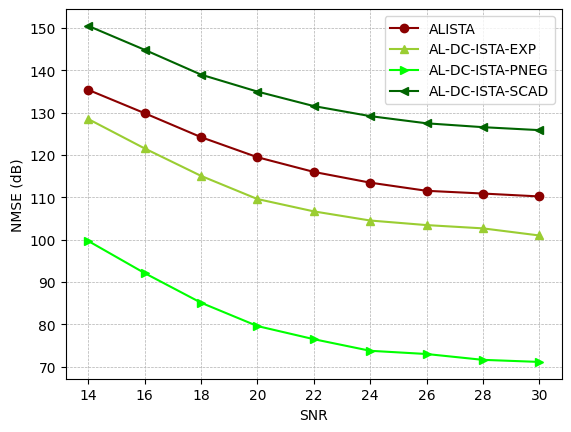

In [21]:
models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]

for i, model_ in enumerate(models):
    plt.plot(SNRs, [reconstruction_errors[SNR][model_] / 10 for SNR in SNRs], label = model_, color = colors[i], marker = markers[i])

plt.xticks(SNRs)

plt.ylabel('NMSE (dB)')
plt.xlabel('SNR')

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

___________

# Unsupervised version

In [10]:
model_1 = ALISTA(torch.clone(D), 1, T = 16)
layerwise_train_U(model_1, train_dataloader, val_dataloader, 'ALISTA', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_2 = ALDC_ISTA(torch.clone(D), 'EXP', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_2, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'EXP', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_3 = ALDC_ISTA(torch.clone(D), 'PNEG', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_3, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'PNEG', lr = 3e-3, ft_lr = 3e-5, verbose=False)

model_4 = ALDC_ISTA(torch.clone(D), 'SCAD', 1, T = 16, W = torch.clone(model_1.W).to('cuda:0'))
layerwise_train_DC_U(model_4, train_dataloader, val_dataloader, 'AL-DC-ISTA', 'SCAD', lr = 3e-3, ft_lr = 3e-5, verbose=False)

Linear layer initialized minimizing coherence!


({'Layer_1': array([ -3.1052417 , -11.17486907, -12.07840226, -11.96118019,
         -12.33945169, -11.58123445, -12.13527887, -11.93223102,
         -11.76014386, -12.18682564, -12.37717698, -12.0918742 ,
         -11.9038669 , -12.34981667, -11.75863973, -12.21884597,
         -11.98356452, -12.32928657, -12.36866446, -12.04199766,
         -12.30395207, -12.35233841, -11.93900821, -12.52447061,
         -12.01369779, -12.44583821]),
  'Fine_Tune': array([-57.59747412, -57.65369842, -57.78284408, -57.55323722,
         -57.62672161, -57.58452467, -57.37384844, -57.31045182,
         -57.28538044, -57.22471069, -57.14096663, -57.03050022,
         -57.14535241, -57.09117238, -56.99939917, -57.09026644,
         -57.0316039 ]),
  'Layer_2': array([-13.3296991 , -16.39283117, -19.07906069, -21.44310904,
         -20.61469361, -20.81317015, -21.19916283, -21.30303089,
         -20.9079307 , -21.07809566, -21.20981029, -21.22229214,
         -21.05355018, -21.19689932, -20.87827112, -20.7

In [23]:
def reconstruction_error(model, D, test_set):
    # Reset the losses accumulator
    total_loss = 0
    total_signal_power = 0

    # Iterate over test_set
    with torch.no_grad():
        for _, Y in enumerate(test_set):
            Y = Y.to(model.device)
            # Forward pass to get the reconstructed signal
            X_hat = model.forward(y=Y, its=None, S=None)

            # Calculate signal power
            total_signal_power += torch.sum(Y.detach() ** 2)

            # Calculate reconstruction loss
            loss = F.mse_loss(Y.T, D.to(model.device) @ X_hat.T, reduction="sum")
            total_loss += loss.item()  # Accumulate loss

    # Avoid division by zero
    if total_signal_power.item() == 0:
        return float('inf')  # or return a large error value

    # Calculate the reconstruction error in dB
    error_db = 10 * torch.log10(total_loss / total_signal_power)

    return error_db.item()  # Return as a Python float


In [24]:
SNRs = np.arange(14,31,2)

reconstruction_errors = {
    SNR : {
        'ALISTA':0,
        'AL-DC-ISTA-EXP':0,
        'AL-DC-ISTA-PNEG':0,
        'AL-DC-ISTA-SCAD':0
} for SNR in SNRs}

for SNR in tqdm(SNRs):

    for m in range(20):
        
        test_dataset = ImagePatchDataset(test_folder_path, patch_size=patch_size, total_patches=1000, transform=transform, SNR = SNR)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

        reconstruction_errors[SNR]['ALISTA'] += reconstruction_error(model_1, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-EXP'] += reconstruction_error(model_2, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-PNEG'] += reconstruction_error(model_3, D, test_dataloader)
        reconstruction_errors[SNR]['AL-DC-ISTA-SCAD'] += reconstruction_error(model_4, D, test_dataloader)

  0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [8:42:14<4:21:07, 5222.46s/it]


KeyboardInterrupt: 

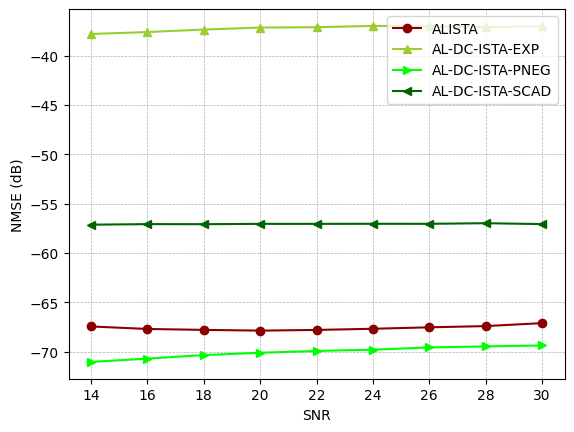

In [13]:
models = [
    'ALISTA',
    'AL-DC-ISTA-EXP',
    'AL-DC-ISTA-PNEG',
    'AL-DC-ISTA-SCAD'
]

colors = [
    'darkred',
    'yellowgreen',
    'lime',
    'darkgreen'
]

markers = [
    'o',
    '^',
    '>',
    '<'
]

for i, model_ in enumerate(models):
    plt.plot(SNRs, [reconstruction_errors[SNR][model_] / 20 for SNR in SNRs], label = model_, color = colors[i], marker = markers[i])

plt.xticks(SNRs)

plt.ylabel('NMSE (dB)')
plt.xlabel('SNR')

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [13]:
torch.save(model_1.state_dict(), "model_1_REAL_weights.pth")
torch.save(model_2.state_dict(), "model_2_REAL_weights.pth")
torch.save(model_3.state_dict(), "model_3_REAL_weights.pth")
torch.save(model_4.state_dict(), "model_4_REAL_weights.pth")

In [55]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def crop_to_multiple_of_16(img):
    w, h = img.size
    new_w = w - (w % 16)
    new_h = h - (h % 16)
    return img.crop((0, 0, new_w, new_h))

def add_gaussian_noise(patches, snr):
    for i in range(patches.shape[0]):
        signal_power = torch.mean(patches[i,:] ** 2)
        noise_power = signal_power / snr
        noise = torch.randn_like(patches[i,:]) * torch.sqrt(noise_power)
        noisy_img = patches[i,:] + noise
    return noisy_img

def rebuild_image(patches, original_size):

    patch_size = 16
    patches_per_row = original_size[0] // patch_size
    patches_per_col = original_size[1] // patch_size

    patches = patches.view(patches_per_col, patches_per_row, patch_size, patch_size)

    img = torch.cat([torch.cat([patches[i, j] for j in range(patches_per_row)], dim=1)
                     for i in range(patches_per_col)], dim=0)

    return img



# Pipeline to process image
def process_image(image_path, snr=0):
    # Load image
    img = Image.open(image_path).convert('L')  

    # Crop to closest multiple of 16
    img = crop_to_multiple_of_16(img)
    original_size = img.size  
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  
    ])
    img_tensor = transform(img)


    patches = img_tensor.unfold(1, 16, 16).unfold(2, 16, 16)
    patches = add_gaussian_noise(patches, snr)
    patches = patches.contiguous().view(-1, 256)  

    return img_tensor, patches, patches, original_size

def display_images(original, noisy, denoised=None):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(noisy, cmap='gray')
    ax[1].set_title("Noisy Image")
    ax[1].axis('off')

    if denoised is not None:
        ax[2].imshow(denoised, cmap='gray')
        ax[2].set_title("Denoised Image")
        ax[2].axis('off')

    plt.show()

image_path = r"C:/Users/Leonardo/Documents/GitHub/ModelBasedDL4SCA/Sparse analysis/real_data/images/test/302022.jpg"
original_tensor, noisy_tensor, patches, original_size = process_image(image_path, snr=40)